# Chapter 7: Advanced examples of Bayesian statistics

## Bayesian Billiards
A famous thought experiment comparing the Bayesian and frequentist approach is 'Bayesian billiards'. (This explanation and calculation were inspired by Eddy (2004).)

Alice and Bob are playing a game in a casino.
The first to get 6 points wins.
There is a pool table which both contestants cannot see.
Before the game starts, the casino rolls a ball randomly onto the table.
Alice gets a point if a subsequent ball comes to rest at a position to the left of the initial ball, and Bob will receive a point if it stops to the right.
Suppose Alice is ahead with 5 points to 3. What is the probability that Bob will win?

Denote by $p$ the fraction of the table to the left of the initial ball.
Due to the set-up of the game, $p$ is unknown.
The game can be seen as a repeated Bernoulli experiment, i.e. a binomial experiment.
Each round, there is chance $p$ that Alice wins, and $1-p$ that Bob wins.
Let $N$ be the total number of rounds that were played, and $N_A$, $N_B$ the amount of rounds that Alice, resp. Bob wins.

The frequentist approach would be to estimate $p$ with a maximum likelihood estimate (MLE). For a binomial experiment, this MLE is $\hat p_{MLE}=\frac{N_A}{N}$, the fraction of times the ball ended up on the left side. Here, this results in $\hat p_{MLE}=5/8$. The estimated probability that Bob will make a 'comeback win' is $(1-\hat p)^3=27/512$, and for Alice the odds are $485/512$. However, as we'll see later, this result is not correct.

One intuitive way to see this, is to recognize that if Alice were 5-0 ahead, the prediction of $p$ would be $\hat p_{MLE}=1$. This would mean that Bob has $0\%$ chance of winning, but intuitively we expect the chance to be non-zero, albeit very small.

Now let's think about how a Bayesian would calculate the probability of a win for Bob. We have knowledge about the results of the previous rounds, but no knowledge about $p$. The chance that Bob will win, given $p$, is
$$
P\left(
\text{Bob wins}
| p
\right)
=
(1-p)^3.
$$
The chance that the observed data happened, given $p$ is
$$
P\left(
N_A=5,N_B=3
| p
\right)
=
\binom{N}{5}p^5(1-p)^3,
$$
where $N = N_A + N_B$.
The chance that Bob will win, given the observed results of the previous rounds, is then
\begin{align*}
    P\left(
    \text{Bob wins}|
    N_A=5,N_B=3
    \right)
    &=
    \int_0^1
    P\left(
    \text{Bob wins},p|
    N_A=5,N_B=3
    \right)
    \text{d}p
    &&(\text{the law of total probability})
    \\
    &=
    \int_0^1
    P\left(
    \text{Bob wins}|
    N_A=5,N_B=3, p
    \right)
    P\left(
    p|
    N_A=5,N_B=3
    \right)
    \text{d}p
    &&(\text{the product rule})
    \\
    &=
    \int_0^1
    P\left(
    \text{Bob wins}|
    N_A=5,N_B=3, p
    \right)
    \frac{P\left(
    N_A=5,N_B=3
    |p
    \right)P(p)}
    {P(N_A=5,N_B=3)}
    \text{d}p
    &&(\text{Bayes' theorem})
    \\
    &=
    \int_0^1
    P\left(
    \text{Bob wins}|
    N_A=5,N_B=3, p
    \right)
    \frac{P\left(
    N_A=5,N_B=3
    |p
    \right)P(p)}
    {\int_0^1 P(N_A=5,N_B=3|p)P(p)\text{d}p}
    \text{d}p
    &&(\text{the law of total probability})
    \\
    &=
    \frac{\int_0^1
    (1-p)^3
    \binom{8}{5} p^5(1-p)^3P(p)
    \text{d}p}
    {\int_0^1 \binom{8}{5}p^5(1-p)^3P(p)\text{d}p},
\end{align*}
which we can only solve if we know the distribution of $p$.

Now we have reached the reason that the Bayesian approach is fundamentally different than the frequentist one; we know how our parameter is distributed. A frequentists statistician would find the notion of a distribution of $p$ weird: how can one parameter, that already a fixed value by the time the experiment starts, still have a distribution? However, in this setting we know that the ball was initially thrown at random on the table, and thus $p$ has a uniform distribution between 0 and 1 (so $P(p)=1$ for all $0\leq p\leq 1$). The rest of the integral can be solved by using the following integral equality:

$$
\int_0^1
p^n(1-p)^m
\text{d}p
=
\frac{n!\, m!}{(n+m+1)!} \tag{7.1}
$$
for non-zero integers $n,m$. The chance of Bob winning is
\begin{align*}
    P\left(
    \text{Bob wins}|
    N_A=5,N_B=3
    \right)
    &=
    \frac{\int_0^1
    p^5(1-p)^6
    \text{d}p}
    {\int_0^1 p^5(1-p)^3\text{d}p}
    \\
    &=
    \frac{5!\,6!/(12!)}
    {5!\,3!/(9!)}
    \\
    &=1/11,
\end{align*}
which is higher than the result from the frequentist method.

To see how the estimators compare, let's do a simulation and compare to the two theoretical methods we've seen.

In [2]:
import numpy as np
import math

In [3]:
#defining functions needed for simulation
def MLE_comeback(n, n_B):
    '''
    Alice has n-1 points, Bob n_B. what is probability that Bob will reach n first?
    Using MLE method.

    Input:
    - n: total number needed for winning
    - n_B: number of points Bob has when Alice has n-1 points

    Output:
    - Probability of Bob making comeback-win, using an MLE for p
    '''
    p = (n-1)/(n-1+n_B) #MLE of Alice winning one round
    chance_comeback_Bob = (1-p)**(n-n_B)
    return chance_comeback_Bob

def Bayes_comeback(n, n_B):
    '''
    Alice has n-1 points, Bob n_B. what is probability that Bob will reach n first?
    Using Bayesian method.

    Input:
    - n: total number needed for winning
    - n_B: number of points Bob has when Alice has n-1 points

    Output:
    - Probability of Bob making comeback-win, using Bayesian calculation
    '''
    numerator = math.factorial(n-1) * math.factorial(n) / math.factorial(2*n)
    denominator = math.factorial(n-1) * math.factorial(n_B) / math.factorial(n+n_B)
    return numerator / denominator

def simulate_BB(n_trials, n_win):
    '''
    Bayesian Billiards simulation:
    compare the frequentist ML prediction with the Bayesian
    by simulating the experiment

    Input:
    - n_trials: total number of trials
    - n_win: the amount of wins needed

    Output:
    - array of length (n_win-1), where in element i
      is the fraction of times a score of 5-i (or i-5)
      was followed by a comeback-win
    '''
    black = np.random.random(n_trials) #calculate location of initial ball
    white = np.random.random((n_trials ,2*n_win-1)) # for each trial, simulate 2*n-1 balls

    # the 0'th index is in how many rounds the score was 5-0 or 0-5
    # the 1st: 5-1 or 1-5, etc
    total_rounds_with_one_setup = np.zeros(n_win-1)

    # the 0'th index is in how many rounds the score was 5-0,
    # and the 2nd player had a comeback win
    # the 1st: 5-1, etc
    comeback_win_rounds_with_one_setup = np.zeros(n_win-1)

    #Here we calculate each round in sequence
    for i in range(n_trials):

        n_A = 0 #rounds for Alice
        n_B = 0 #round for Bob
        j = 0 #the current round

        #playing until one player is 5-x ahead
        while(n_A<n_win-1 and n_B<n_win-1):
            if(white[i,j] < black[i]):
                n_A += 1
            else:
                n_B += 1
            j += 1

        if(n_A == n_win-1): #Alice is 5-x ahead
            Alice_ahead = True
            points_when_behind = n_B
        else: # Bob is x-5 ahead
            Alice_ahead = False
            points_when_behind = n_A
        total_rounds_with_one_setup[points_when_behind] += 1

        #playing until one player won
        while(n_A<n_win and n_B<n_win):
            if(white[i,j] < black[i]):
                n_A += 1
            else:
                n_B += 1
            j += 1

        if(n_A == n_win and Alice_ahead==False): #Alice wins with a comeback
            comeback_win_rounds_with_one_setup[points_when_behind] += 1
        elif(n_B == n_win and Alice_ahead==True): #Bob wins with a comeback
            comeback_win_rounds_with_one_setup[points_when_behind] += 1

    chance_of_comeback = comeback_win_rounds_with_one_setup / total_rounds_with_one_setup
    return chance_of_comeback

In [4]:
n_trials = 1e6 #amount of games that are simulated
n_win = 6 #number of rounds needed to win

simulation_prob_comeback_win = simulate_BB(int(n_trials), n_win)
MLE_prob_comeback_win = [MLE_comeback(n_win, i) for i in range(n_win-1)]
Bayes_prob_comeback_win = [Bayes_comeback(n_win, i) for i in range(n_win-1)]

print("The simulated comeback probabilities, along with the predicted values.")
print("    || Simulation ||   MLE   ||  Bayes")
for i in range(n_win-1):
    print(f"{i}-5 ||   {simulation_prob_comeback_win[i]:.5f}  || {MLE_prob_comeback_win[i]:.5f} || {Bayes_prob_comeback_win[i]:.5f}")

The simulated comeback probabilities, along with the predicted values.
    || Simulation ||   MLE   ||  Bayes
0-5 ||   0.00109  || 0.00000 || 0.00108
1-5 ||   0.00774  || 0.00013 || 0.00758
2-5 ||   0.02994  || 0.00666 || 0.03030
3-5 ||   0.09059  || 0.05273 || 0.09091
4-5 ||   0.22846  || 0.19753 || 0.22727


The Bayesian method consistently gives approximately the same answer as the simulation, while the MLE gives worse predictions.

## Sigma clipping

Sigma clipping is a commonly used method to reject outliers within astronomy. Data that is more than a certain number of standard deviations ($\sigma$) away from the sample's median (which tends to be robust than using the mean), is rejected and removed from the sample, assuming the sample is distributed normally otherwise. If the maximum accepted distance from the median is *n* standard deviations, then for data point $y_i$

$$
y_i=
\begin{cases}
\text{1} &\text{(median - $n*\sigma$) < $y_i$ < (median + $n*\sigma$)}\\
\text{0} &\text{otherwise}
\end{cases}
$$

Where if $y_i = 0$, it is an outlier.

This method can be applied iteratively on a sample of data to remove unwanted data points. Each iteration changes the median and standard deviation, this affects which data points will be considered outliers. This will go on until there are no longer data points recognized as outliers.

A simple example of how this is done can be seen in the code below.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Below we define a function that generates a random set of data, the data points have some *(x,y)* value and *colour* assigned. To keep the problem simple, only the y-axis values will be of importance for sigma clipping. In other words, this is a 1D problem.

In [5]:
def generate_normal_distributed(mean=100, std=20, size=1000, outlier_std=40, outlier_size=100):
    '''
    Generate some random data points with outliers
    mean: Set the mean value around which the data points will be generated
    std: The size of the error of good data points
    size: The amount of good data points
    outlier_std: The size of the error of bad data points
    outlier_size: The amount of outliers
    '''
    data_colour = np.full((size,), "#0173b2") #blue
    data_y = np.vstack((np.random.normal(mean, std, size), data_colour), dtype=object)

    outliers_colour = np.full((outlier_size,), "#de8f05") #yellow
    outliers_y = np.vstack((np.random.normal(mean + (np.random.choice((-1, 1), outlier_size)*np.random.rand(outlier_size)*mean),
                                             outlier_std, outlier_size), outliers_colour), dtype=object)
    data = np.concatenate((data_y,outliers_y), axis=1)

    x_value = np.random.uniform(0,100, size=size+outlier_size)
    data = np.vstack((x_value, data), dtype=object) #Append randomized x-axis values to the data points to spread out points
    np.random.shuffle(data.T)

    return data

Let's see what this data looks like:

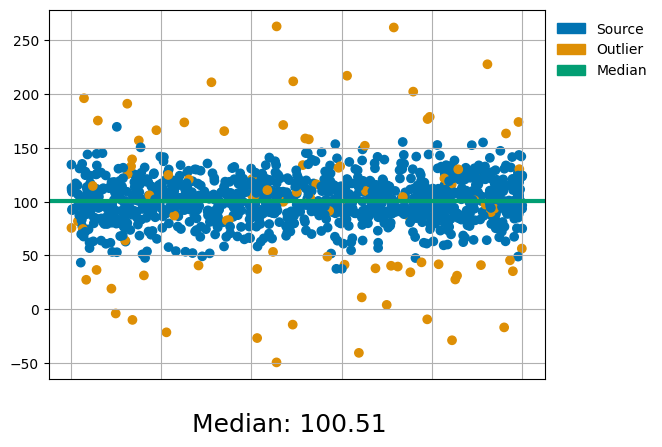

In [6]:
data = generate_normal_distributed() #Generate some random sample
Data_median = np.median(data[1,:])

# Create a legend with a color box
blue_point = mpatches.Patch(color='#0173b2', label='Source') #blue
yellow_point = mpatches.Patch(color='#de8f05', label='Outlier') #yellow
green_line = mpatches.Patch(color='#029e73', label='Median') #green

#Plot the figure
plt.scatter(data[0,:],data[1,:],c=data[2,:])
plt.axhline(Data_median, color="#029e73", linestyle="-", linewidth=3) #green
plt.tick_params(axis='x', which='both', bottom = False, labelbottom=False) #Remove X-axis label
plt.legend(handles=[blue_point, yellow_point, green_line], loc='upper left', framealpha=0.5, frameon=False ,bbox_to_anchor=(1.0, 1))
Figtext_Data_median = str("Median: ") + str(round(Data_median,2))
plt.figtext(0.5, 0, Figtext_Data_median, ha="center", va="baseline", fontsize=18)
plt.grid()
plt.show()

If we plot this data in a histogram with a probability density it, would like this:

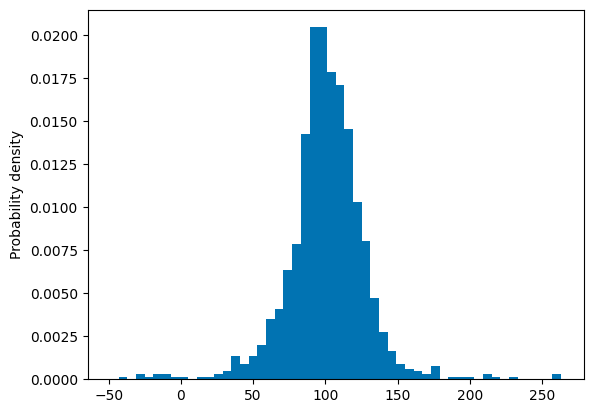

In [7]:
bin_width = round((max(data[1,:])-min(data[1,:]))/50) #used to keep bin widths equal across plots
plt.hist(data[1,:],bins=range(int(min(data[1,:])), int(max(data[1,:])) + bin_width, bin_width), density=True, color="#0173b2")
plt.ylabel("Probability density")
plt.show()

To remove the outliers we make use of another function which applies sigma clipping. To add insight into what happens, some code to add figures has been inserted. There is some freedom in the way sigma clipping is applied by changing the parameters; *nsigma* determines the boundaries and *niter* determines up to how many times the sample will be tested for outliers.

In [8]:
medians = [] #An empty list to record the median values
means = [] #An empty list to record the mean values
def sigmaclip(sample, nsigma=3.0, niter=100, plot_first_x_iterations=0, iterations_done=0, show_final_step=False):
    '''
    Apply 1 dimensional sigma clipping to data
    sample: Some data to apply 1 dimensional sigma-clipping on the y-axis value
    nsigma: A float that determines up to how many standard deviations a data point can be from the median
    niter: An integer value that determines up to how many times the function should loop
    plot_first_x_iterations: An integer that determines how many of the first iterations should be shown through plots
    iterations_done: A counter to see how many iterations have been done, do not change this! (also required for listing all median values correctly)
    show_final_step: A boolean (True or False) that determines whether the final step should be shown through a plot
    '''
    #The code to apply sigma clipping
    std = np.std(sample[1,:], ddof=1) #Calculate the standard deviation with delta degrees of freedom set to 1
    med = np.median(sample[1,:]) #Calculate the median
    isok = (np.abs(sample[1,:] - med) / std) < nsigma #Checks if the datapoint is within the boundaries
    top_boundary = np.median(sample[1,:]) + nsigma*(np.abs(std))
    bottom_boundary = np.median(sample[1,:]) - nsigma*(np.abs(std))

    if iterations_done == 0: #When sigma clipping is started, reset the list of median values
        medians.clear()
        means.clear()
    medians.append(round(med,2))
    mean = np.mean(sample[1,:]) #Calculate the mean
    means.append(round(mean,2))

    if (niter <= 0) or (isok.sum() == sample[1,:].size): #When the sample has been iterated niter times or there is no change in the sample

        #Plot figure if True
        if show_final_step == True:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 7)) #Plot 3 fig: the before, the added boundary and the after situation
            ax1.scatter(sample[0,:],sample[1,:],c=sample[2,:])
            ax1.tick_params(axis='x', which='both', bottom = False, labelbottom=False) #Remove X-axis label
            ax1.tick_params(axis='y', which='both', labelsize=12) #Increase the y-tick label size
            ax2.scatter(sample[0,:],sample[1,:],c=sample[2,:])
            ax2.tick_params(axis='x', which='both', bottom = False, labelbottom=False) #Remove X-axis label
            ax2.axhline(y = top_boundary, color="#029e73", linestyle="-", linewidth=2.5) #Add a line to represent the top boundary
            ax2.axhline(y = bottom_boundary, color="#029e73", linestyle="-", linewidth=2.5) #Add a line to represent the bottom boundary
            ax3.scatter(sample[0,:],sample[1,:],c=sample[2,:])
            ax3.tick_params(axis='x', which='both', bottom = False, labelbottom=False) #Remove X-axis label
            ax1.set_title("Before", fontsize=16)
            ax2.set_title("Decision Boundary", fontsize=16)
            ax3.set_title("After", fontsize=16)
            fig.tight_layout()
            fig.subplots_adjust(top=0.84, bottom=0.06)
            fig.suptitle('Last iteration: ' + str(iterations_done+1), fontsize=24)
            Description ="\nMedian: "+str(round(med,2))+"\nTop boundary: "+str(round(top_boundary,2))+"\nBottom boundary: "+str(round(bottom_boundary,2))
            plt.figtext(0.04, 0, Description, ha="left", va="center", fontsize=14)
            plt.show()

        #Return the filtered dataset
        return sample, medians, means

    if (iterations_done < plot_first_x_iterations): #Plot the first x amount of iterations for visual representation
        #Plot figure
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 7)) #Plot 3 fig: the before, the added boundary and the after situation
        ax1.scatter(sample[0,:],sample[1,:],c=sample[2,:])
        ax1.tick_params(axis='x', which='both', bottom = False, labelbottom=False) #Remove X-axis label
        ax1.tick_params(axis='y', which='both', labelsize=12) #Increase the y-tick label size
        ax2.scatter(sample[0,:],sample[1,:],c=sample[2,:])
        ax2.tick_params(axis='x', which='both', bottom = False, labelbottom=False) #Remove X-axis label
        ax2.axhline(y = top_boundary, color="#029e73", linestyle="-", linewidth=2.5) #Add a line to represent the top boundary
        ax2.axhline(y = bottom_boundary, color="#029e73", linestyle="-", linewidth=2.5) #add a line to represent the bottom boundary
        ax3.scatter(sample[0,isok],sample[1,isok],c=sample[2,isok])
        ax3.tick_params(axis='x', which='both', bottom = False, labelbottom=False) #Remove X-axis label #Remove X-axis label
        ax1.set_title("Before", fontsize=16)
        ax2.set_title("Decision Boundary", fontsize=16)
        ax3.set_title("After", fontsize=16)
        fig.tight_layout()
        fig.subplots_adjust(top=0.84, bottom=0.06)
        fig.suptitle('Iteration: ' + str(iterations_done+1), fontsize=24)
        Description ="\nMedian: "+str(round(med,2))+"\nTop boundary: "+str(round(top_boundary,2))+"\nBottom boundary: "+str(round(bottom_boundary,2))
        plt.figtext(0.04, 0, Description, ha="left", va="center", fontsize=14)
        plt.show()

    #Go to the next iteration
    return sigmaclip(sample[:,isok], nsigma, niter-1, plot_first_x_iterations, iterations_done+1, show_final_step)

Let's see sigma clipping in action:

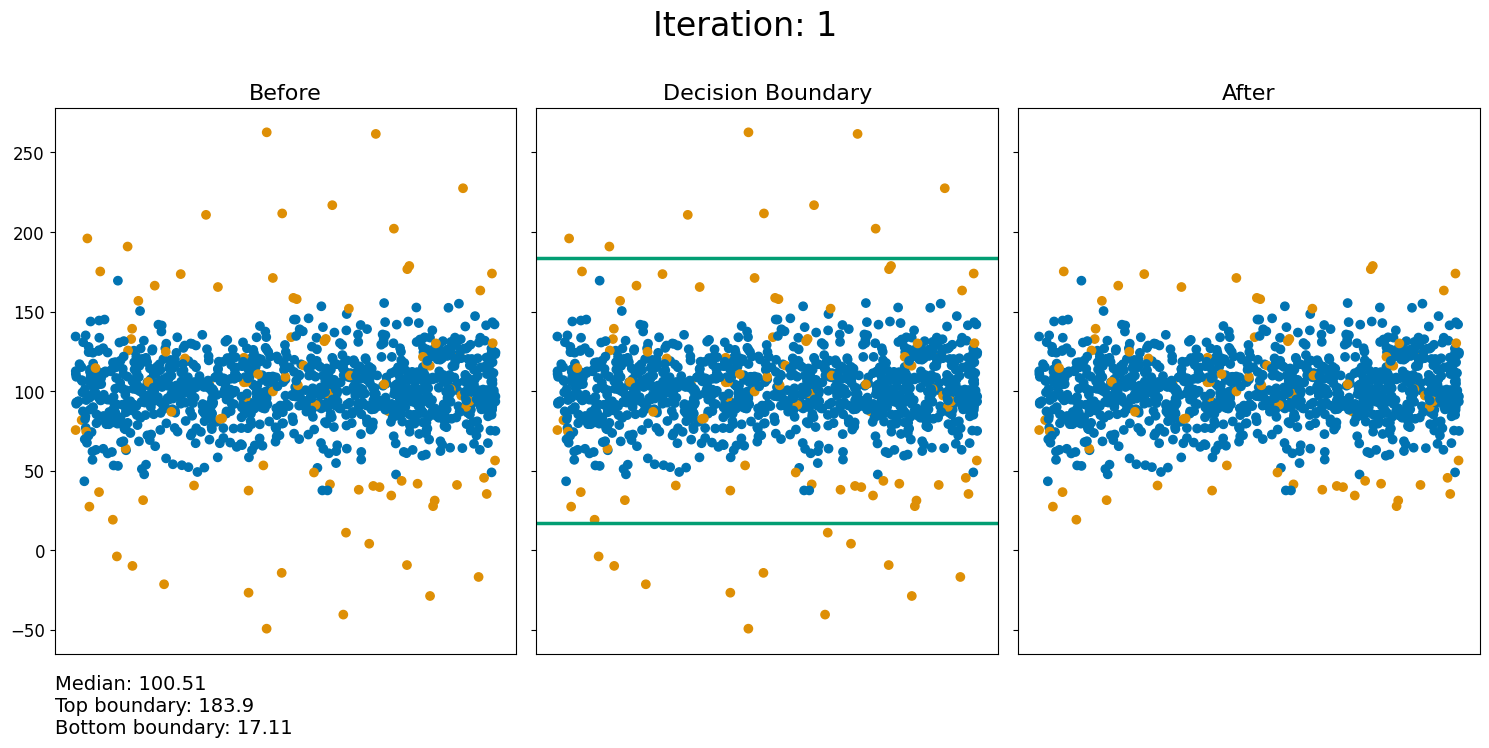

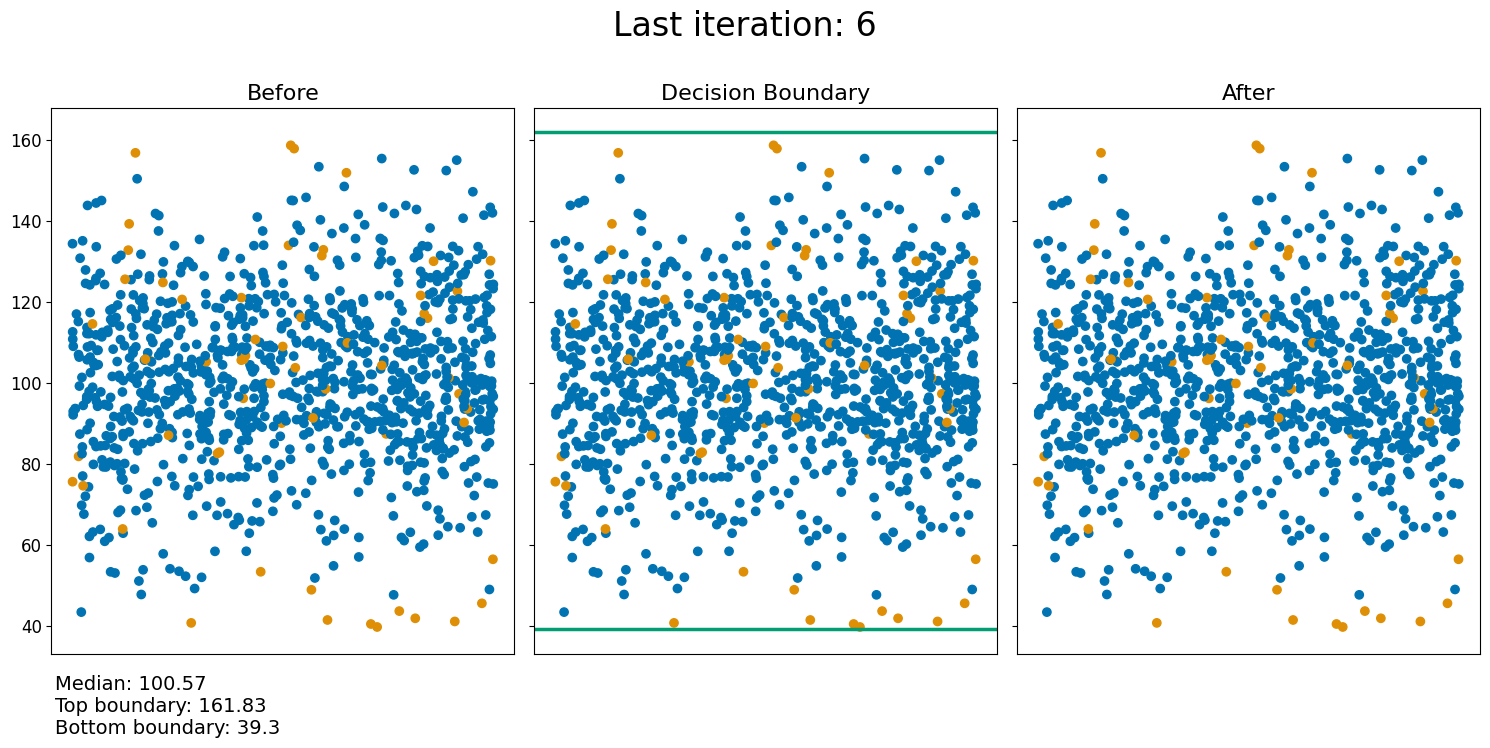

In [9]:
newdata, median_values, mean_values = sigmaclip(data, plot_first_x_iterations=1, show_final_step=True) #Filter the sample using sigma clipping

As can be seen from the figures above, the way outliers are removed from the data is by defining some boundary depending on $\sigma$, where each point outside the boundary is removed from the data. After removing the outliers from the sample, the new sample is used to calculate new boundaries and remove points that are outside this boundary. This will keep going until the maximum amount of iterations have been applied, or there is no change in the sample compared to the previous iteration.

Due to these sample changes the median and mean also change with each iteration, this can be seen in the figures below.

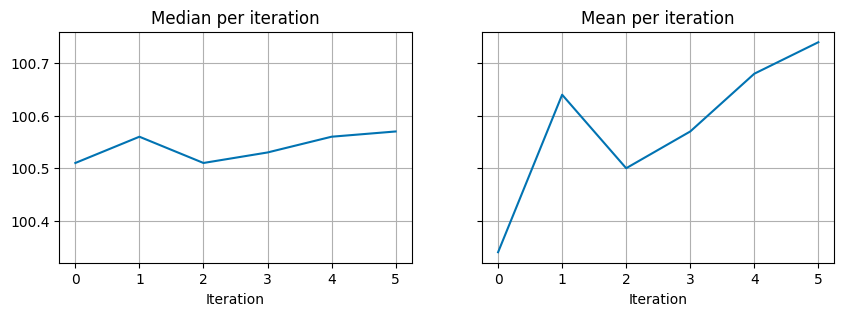

In [10]:
#Create a figure to visualise the change in median and mean values
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 3))
ax1.plot(np.arange(len(median_values)),median_values, c="#0173b2")
ax1.set_xticks(range(0,len(median_values))) #Set the x-ticks to integers
ax1.title.set_text('Median per iteration')
ax1.set_xlabel('Iteration')
ax1.grid()

ax2.plot(np.arange(len(mean_values)),mean_values, c="#0173b2")
ax2.set_xticks(range(0,len(median_values))) #Set the x-ticks to integers
ax2.title.set_text('Mean per iteration')
ax2.set_xlabel('Iteration')
ax2.grid()

plt.show()

The final result can be seen in the figures below:

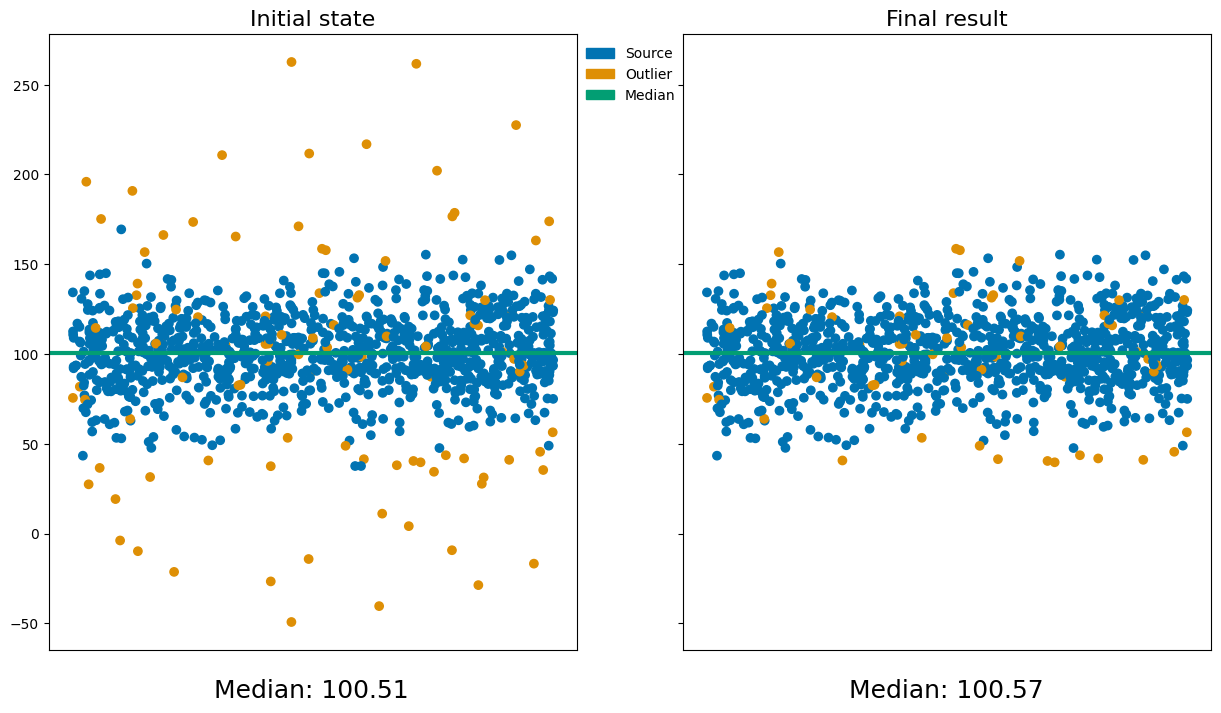

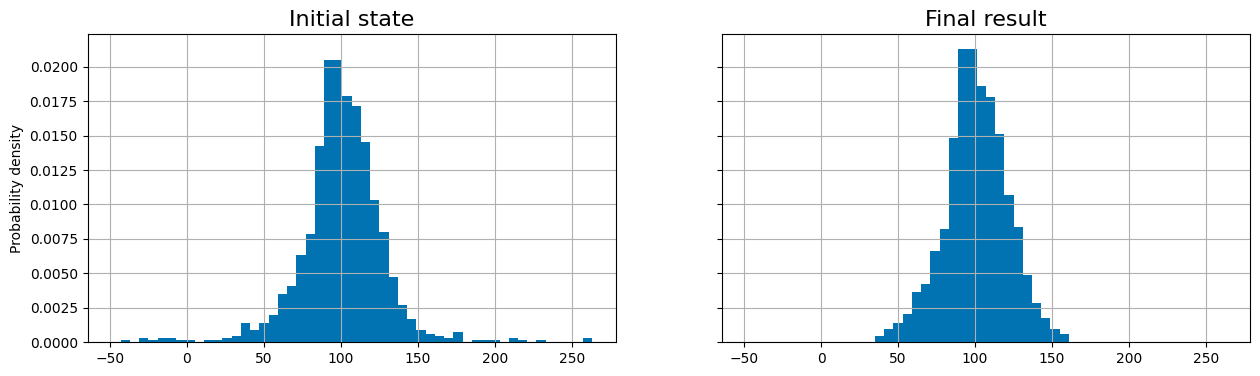

In [11]:
#Plot the before and after of the sample's data
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
ax1.scatter(data[0,:],data[1,:],c=data[2,:])
MedianBefore = str("Median: ") + str(round(np.median(data[1,:]),2))
plt.figtext(0.3, 0.05, MedianBefore, ha="center", fontsize=18)
ax1.axhline(y = np.median(data[1,:]), color="#029e73", linestyle="-", linewidth = 3)
ax1.tick_params(axis='x', which='both', bottom = False, labelbottom=False) #Remove X-axis label
ax2.scatter(newdata[0,:],newdata[1,:],c=newdata[2,:])
MedianAfter = str("Median: ") + str(round(np.median(newdata[1,:]),2))
plt.figtext(0.723, 0.05, MedianAfter, ha="center", fontsize=18)
plt.axhline(y = np.median(newdata[1,:]), color="#029e73", linestyle="-", linewidth = 3)
ax2.tick_params(axis='x', which='both', bottom = False, labelbottom=False) #Remove X-axis label
ax1.set_title("Initial state", fontsize=16)
ax2.set_title("Final result", fontsize=16)
ax1.legend(handles=[blue_point, yellow_point, green_line], loc='upper right', frameon=False ,bbox_to_anchor=(1.21, 1.0))
plt.show()

#Plot the before and after probability densities in a histogram
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(15, 4))
ax1.hist(data[1,:],bins=range(int(min(data[1,:])), int(max(data[1,:])) + bin_width, bin_width), density=True, color="#0173b2")
ax2.hist(newdata[1,:],bins=range(int(min(data[1,:])), int(max(data[1,:])) + bin_width, bin_width), density=True, color="#0173b2")
ax1.set_ylabel('Probability density')
ax1.set_title("Initial state", fontsize=16)
ax2.set_title("Final result", fontsize=16)
ax1.grid()
ax2.grid()
plt.show()

Even though not all outliers have been removed, the end result ensures that all data points are within the chosen n-$\sigma$ significance.

This method is rather simple, but also quite restrictive when it comes to dealing with more complex situations, for example when the data is not normally distributed. In this case it would be wise to think about rejecting outliers using MCMC, a Bayesian method.

## Rejecting Outliers with a Bayesian approach
$\def\f{\frac} \def\L{\mathcal{L}}$
Standard fitting methods, for example making a linear fit, are very sensitive to outliers, points that are significantly far away from the expected relation. Therefore it is neccesary to prune for these outliers to get the expected relation. However, if you prune too many outliers, the number of datapoints reduces a lot, which causes a higher error on the parameters of the fit.

When doing measurements of a certain physical relation, you would not expect all points to be within one standard deviation of the theoretical relation. If you take a big enough sample, we can assume a normal distribution (due to the central limit theorem), where the chance of getting a datapoint outside of the $1-\sigma$ region is about $32%$. Therefore, you would about a third of the measurements to be (at least) $1-\sigma$ away from the theoretical relation. As we go further and further away from the relation, we expect less and less datapoints there. An outlier can substantially change the fit, for example, it can substantially change the mean. Outliers can have multiple causes, examples would be unmodeled experimental uncertainty or (rare) noise sources, which we aren't always able to account for. One method of removing outliers is to select them by hand. However, as one could imagine, this is far from ideal, especially with large datasets. It is an extremely time consuming, subjective and hard to reproduce.

We need a more systematic way of rejecting outliers (explanation and calculation inspired by Hogg et al, 2010). Let $y_1, \dots, y_N$ be an independent and identically distributed (iid) sample. For simplicity, let us look at data sampled from a linear relation (a straight line):
$$ y_i = ax_i + b + \varepsilon_i, \tag{7.2} $$
with $\varepsilon_1, \dots, \varepsilon_N$ iid with $\varepsilon_1 \sim \mathcal{N}(0, \sigma_\varepsilon^2)$. Note that in the theoretical model, there is no need to model the $\varepsilon$, but in the data we will get some error term, which can be modeled using deviations with mean 0. Let $(q_1, \dots, q_N)$ be a set of $N$ binary integers, where $q_i$ is $1$ if the $i$-th datapoint is "good" and $q_i$ is $0$ if the $i$-th datapoint is "bad"; an outlier:
$$
    q_i = \begin{cases}
    1 & \text{if } y_i\text{ is an inlier}, \\
    0 & \text{if } y_i\text{ is an outlier}.
    \end{cases} \tag{7.3}
$$
Furthermore, let $P_b$ be the prior probability that any (individual) datapoint is bad and let $(Y_b, V_b)$ be the mean and variance of the distribution of bad points. Finally, let $I$ be all other information. Note that these extra parameters will be marginalized out. Therefore, we do not need to worry about the fact that we have more datapoints than our "actual" datapoints.

To formalize this method, we need a <b>generative model</b>, which is defined as a parameterized, quantitative description of a statistical procedure that could have reasonably generated a dataset similar to the one you have.

Let $p$ be the gegenerative model for the datapoints $\{y_i\}^N_{i=1}$. Then, the generative model for a general (Gaussian) statistical model is given by:
$$
p(y_i | x_i, \sigma_{y_i}, \hat{\theta}) = \f{1}{\sqrt{2\pi \sigma_{y_i}^2}} \exp\left(-\f{[y_i - Y_i]^2}{2\sigma^2_{y_i}}\right) , \tag{7.4}
$$
where $y_i$ is the datapoint, $\sigma_{y_i}^2$ the error on the datapoint, $Y_i$ the outcome of the model, $x_i$ an independent position (which is incorporated into $Y_i$) and $\hat{\theta}$ the model parameters. For example, for a linear model with slope $a$ and zeropoint $b$, we get $Y_i = a x_i + b$, with $\hat{\theta} = (a, b)$.

Let us go back to the linear model again, and let $p_g$ be the generative model for the "good" datapoints and $p_b$ be the generative model for the "bad" datapoints. Then the "total" generative model $p$ will be given by a combination of $p_b$ and $p_g$. We look for the model that maximizes the probability of the observed data, given the model and other factors. Hence, we will calculate the likelihood.  Then, we can see:
\begin{align*}
\L
&= p(\{y_i\}^N_{i=1}| a, b, \{q_i\}^N_{i=1}, Y_b, V_b, I)
\\
& = \prod_{i=1}^N p(y_i | a,b, q_i, n, Y_b, V_b, I)
&&
(\text{since the $y_i$ are iid})
\\
&=
\prod_{i = 1}^N \left[p_g(y_i| a,b, I)\right]^{q_i} \left[p_b(\{y_i\}^N_{i=1}| Y_b, V_b, I)\right]^{1-q_i}
\\
&=
\prod_{i = 1}^N \left[\f{1}{\sqrt{2\pi \sigma_{y_i}^2}} \exp\left(-\f{[y_i - ax_i - b]^2}{2\sigma^2_{y_i}}\right)\right]^{q_i} \left[\f{1}{\sqrt{2\pi \left[V_b + \sigma_{y_i}^2\right]}} \exp\left(-\f{[y_i - Y_b]^2}{2\left[V_b + \sigma_{y_i}^2\right]}\right)\right]^{1-q_i} \tag{7.5}
\end{align*}

Note that for good datapoints, $q_i = 1$, thus the second term will be unity (since $1-q_i = 0$), and for bad datapoints $q_i = 0$ so the first term will equal 1. So, for bad datapoints, you will (only) sample from $p_b$, and for good datapoints from $p_g$.

Now, as we permit the rejection of some of our data, we must make a prior probability on our values of $q_i$ that penalises each rejection, making it less likely to reject more datapoints, as otherwise we keep rejecting and end up with too few datapoints. The prior probability is given by
$$
p (a,b, \{q_i\}^N_{i=1}, P_b, Y_b, V_b | I) = p(\{q_i\}^N_{i=1} | P_b, I) p (a,b, P_b, Y_b, V_b | I), \tag{7.6}
$$
where $p (a,b, \{q_i\}^n_{i=1}, P_b, Y_b, V_b | I)$ is the prior on all the parameters of the model, $p(\{q_i\}^n_{i=1} | P_b, I)$ the prior on the rejection process and $p (a,b, P_b, Y_b, V_b | I)$ the prior on the model parameters and the parameters describing the bad points, with the product holding because of independence. Furthermore, there holds
$$
p(\{q_i\}^N_{i=1} | P_b, I) = \prod_{i=1}^N [1-P_b]^{q_i} P_b^{[1-q_i]}, \tag{7.7}
$$
as the probability that a datapoint is "bad" is $P_b$, so the probability that a datapoint is good is $1-P_b$: for a single $q_i$ there holds $p(q_i = 1 | P_b) = 1-P_b$ and $p(q_i = 0 | P_b) = P_b$. Thus
$$
p(q_i | P_b) = \left[1-P_b\right]^{q_i}P_b^{1-q_i}.
$$
Using the independence of the $\{y_i\}_{i=1}^N$, thus the independence of the $\{q_i\}_{i=1}^N$, we can see:
$$
p(\{q_i\}_{i=1}^N | P_b ) = \prod_{i=1}^N p(q_i | P_b) = \prod_{i=1}^N \left[1-P_b\right]^{q_i}P_b^{1-q_i}.
$$
Thus $p(\{q_i\}_{i=1}^N | P_b )$ is a binomial probabiltiy of the particular sequenece $\{q_i\}^n_{i=1}$ (see [Chapter 3](https://bayesian-statistics-for-astrophysics-2024.readthedocs.io/en/latest/lecture_notes/group3/chapter3.html) and [Chapter 5](https://bayesian-statistics-for-astrophysics-2024.readthedocs.io/en/latest/lecture_notes/group5/group5.html)).

The prior on the parameters $(P_b, Y_b, V_b)$ should be made without looking at the data. You can either set the prior based on prior knowlege or let the prior be somewhat uninformative, for example $P_b \in [0,1]$. With this, we have made the assumption that all datapoints are equally likely to be bad, which might not always be the case. However, most of the time you don't know enough about the quality of your data (before actually looking at the data) to assume anything better.

One might note that we use a Gaussian model for the bad points. As we don't know much about the bad points, the Gaussian model must be wrong. However, to prune the outliers, you don't have to make an accurate model of the outliers, you just have to model them. When you don't have an accurate model for your bad data, it is best to use the most general model, a Gaussian model, as it is the maximum-entropy probability distribution described by a mean and a variance.

In general, the posterior probability distribution function is the likelihood multiplied by the prior, and then normalized (see [Chapter 5](https://bayesian-statistics-for-astrophysics-2024.readthedocs.io/en/latest/lecture_notes/group5/group5.html)). If we define $\vec{\theta} = \left(a, b, \{q_i\}_{i=1}^N, P_b, Y_b, V_b\right)$ for brevity, we can see for the full posterior probability:
\begin{align*}
p(\vec{\theta}, I) & = p(\vec{\theta}| I)p(I) & \text{(definition of conditional probability)} \\
&= p(\vec{\theta}| I)\f{p(\{y_i\}_{i=1}^N|I)}{p(\{y_i\}_{i=1}^N|I)} \\
&= \f{p(\vec{\theta}, \{y_i\}_{i=1}^N | I)}{p(\{y_i\}_{i=1}^N|I)}  & \text{(as the }y_i \text{ and } \vec{\theta} \text{ are independent)} \\
& = \f{p( \{y_i\}_{i=1}^N |\vec{\theta}, I)}{p(\{y_i\}_{i=1}^N|I)} p(\vec{\theta} | I),  & \text{(definition of conditional probability)}
\end{align*}

where we assumed $p(I) = 1$, as we can assume $I$ is just background information and not probabilistic in nature. The marginalization, to get the distribution function of the parameters of interest, looks like
$$
p(a, b | \{y_i\}_{i=1}^N, I) = \int \text{d}\{q_i\}_{i=1}^N\; \text{d}P_b\; \text{d}Y_b\; \text{d}V_b\; p(\vec{\theta}, I), \tag{7.8}
$$
where the integration over $\text{d}\{q_i\}_{i=1}^N$ is a sum over all $2^N$ possible combinations of the $q_i$, and the integrals over the other parameters being over their prior support (for example if your prior is $P_b \in [0,1]$, you integrate from $0$ to $1$).

In this integral you have to marginalize over a lot of different likelihoods, growing exponentially with $N$. As there are usually only very few points that are outliers (otherwise they wouldn't be outliers), there are multiple ways to do this more efficiently.

The marginalization can be performed by numerical integration, but usually the prefered way is to integrate with some kind of sampler, such as with a Monte-Carlo Markov Chain (MCMC) sampler (see [Chapter 6](https://bayesian-statistics-for-astrophysics-2024.readthedocs.io/en/latest/lecture_notes/group6/Chapter%206.html)). An example of the fitting of a linear model with a MCMC sampler is given below.

#### Example

Let us now look at an example. We generate data around a linear relation $y = ax + b$, with the true values $a = 2.5$ and $b = 1$. We sample from this model, and add some Gaussian noise with a standard deviation of 0.5 to simulate real-world data. We deliberately introduce a few outliers by randomly selecting some outliers and giving them large deviations from the expected linear model.

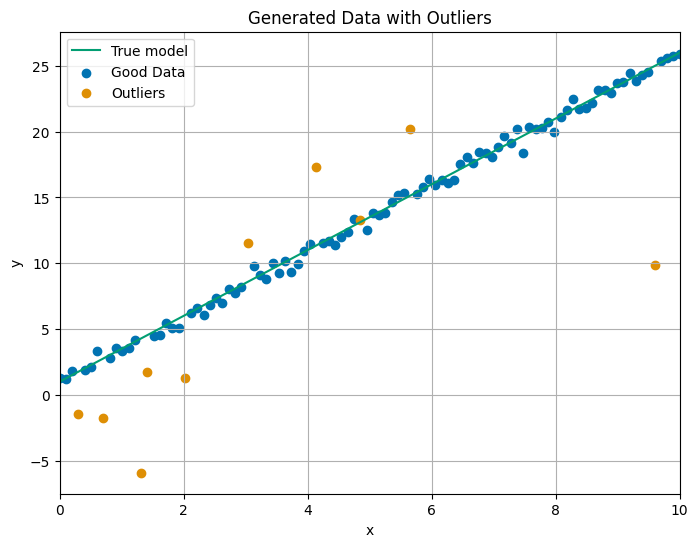

In [6]:
import numpy as np
#!pip install emcee  # installation of emcee
import emcee
import matplotlib.pyplot as plt
np.random.seed(42)

# True parameters
a_true = 2.5
b_true = 1.0
sigma_true = 0.5
P_b_true = 0.1  # probability of outlier
Y_b_true = 10.0  # mean of the bad points
V_b_true = 2.0  # variance of the bad points
N = 100  # number of data points
x = np.linspace(0, 10, N)

# generating good y values
y_true = a_true * x + b_true
y = y_true + np.random.normal(0, sigma_true, size=N)

# introducing some outliers
n_outliers = int(N * P_b_true)
outliers = np.random.choice(range(N), size=n_outliers, replace=False)  # randomly select outliers
y[outliers] += np.random.normal(0, 5, size=len(outliers))  # add large deviation for outliers

plt.figure(figsize=(8, 6))
plt.style.use("seaborn-v0_8-colorblind")
# plotting true model
plt.plot(x, y_true, label="True model", color='#029e73')
# plotting good data
plt.scatter(x[~np.isin(np.arange(N), outliers)], y[~np.isin(np.arange(N), outliers)], label="Good Data", color='#0173b2')
# plotting outliers
plt.scatter(x[outliers], y[outliers], label="Outliers", color='#de8f05')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Generated Data with Outliers")
plt.xlim(0, 10)
plt.grid()
plt.show()

Then, we define the likelihood function, which helps to determine how well the parameters explain the data. The likelihood function calculates the probability of observing the given data based on the distributions for the "good" and "bad" datapoints. We use a weighted sum of the two likelihoods.  

The prior function represents the beliefs we have about the parameters before seeing any data. We assumed "flat" priors, meaning we have no strong prior that would suggest certain values for the parameters are more likely than others. We restrict $a$ and $b$ to be within $[-10, 10]$, $P_b$ within $[0, 1]$ and some limits on $Y_b$ and $V_b$. If the parameters fall outside of these ranges, the prior probability is set to zero (as we are computing the log-likelihood, this is represented by $-\infty$).

Lastly, the posterior function combines the likelihood and the prior. We want to sample from the posterior distribution to learn about the most likely values of the parameters. This function will be used by the Monte Carlo Markov Chain sampler to evaluate
the posterior distribution at different points in the parameter space.

In [7]:
# likelihood function
def log_likelihood(theta, x, y, P_b, sigma_y):
    a, b, Y_b, V_b = theta
    n = len(x)

    # computing the log-likelihood
    ll = 0.0
    for i in range(n):
        # good points
        if np.random.rand() > P_b:
            ll += -0.5 * np.log(2 * np.pi * sigma_y**2) - (y[i] - (a * x[i] + b))**2 / (2 * sigma_y**2)
        # bad points
        else:
            ll += -0.5 * np.log(2 * np.pi * (V_b + sigma_y)**2) - (y[i] - Y_b)**2 / (2 * (V_b + sigma_y)**2)

    return ll

# prior function
def log_prior(theta):
    a, b, Y_b, V_b = theta
    if 0 < P_b_true < 1 and -10 < a < 10 and -10 < b < 10 and -50 < Y_b < 50 and 0 < V_b < 10:
        return 0.0  # flat prior
    else:
        return -np.inf  # if outside the prior range, set prior to 0

# posterior function
def log_posterior(theta, x, y, P_b, sigma_y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, P_b, sigma_y)

Then, we set up the MCMC sampler by using the `emcee` library. We set an initial guess for the model parameters as starting points for the Markov chain. After initializing the walkers at some slightly perturbed positions, we run the MCMC sampler. The result will be a set of parameter samples that represent our posterior belief about the model parameters, including the outlier parameters.

We analyze the results by extracting the samples from the MCMC chain, which represent the posterior distribution of the parameters, and they give us an estimate of the most likely parameter values and their uncertainties. Then, we visualize the best fit line obtained from the MCMC posterior distribution.

You must install the tqdm library to use progress indicators with emcee


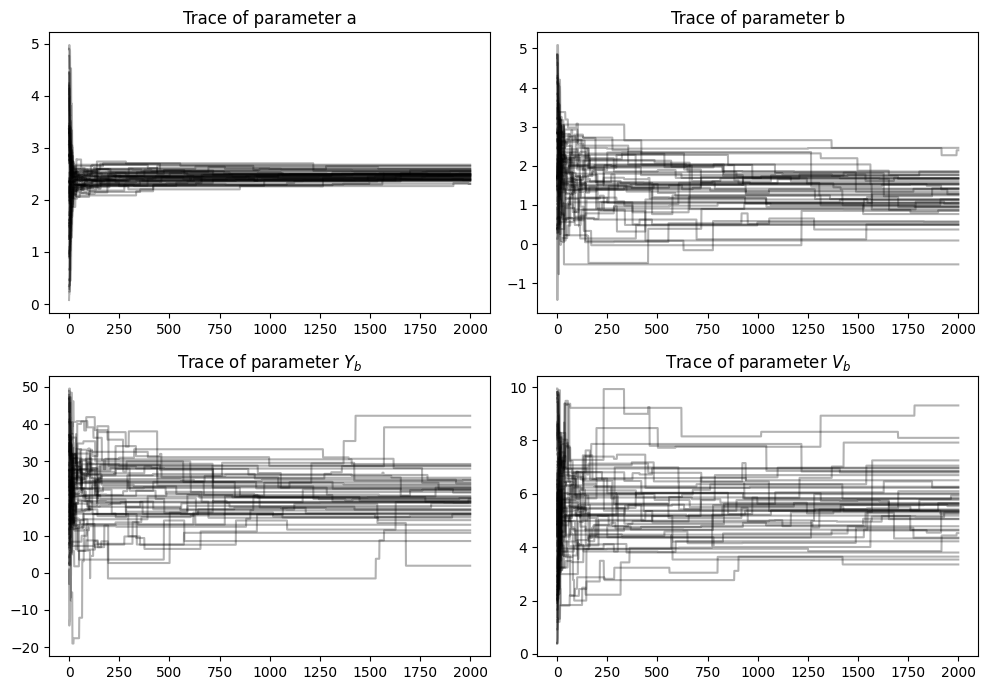

In [8]:
# MCMC sampling
def run_mcmc(x, y, P_b, sigma_y, nwalkers=50, ndim=4, nsteps=2000):
    # initializing positions of walkers
    p0 = [np.random.rand(ndim) * np.array([5, 5, 50, 10]) for i in range(nwalkers)]

    # creating the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, P_b, sigma_y))

    # running the MCMC
    sampler.run_mcmc(p0, nsteps, progress=True)

    return sampler

# running MCMC
P_b = P_b_true
sigma_y = sigma_true
sampler = run_mcmc(x, y, P_b, sigma_y)

# plotting the results
samples = sampler.get_chain()
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
plt.plot(samples[:, :, 0], color="k", alpha=0.3)
plt.title("Trace of parameter a")
plt.subplot(2, 2, 2)
plt.plot(samples[:, :, 1], color="k", alpha=0.3)
plt.title("Trace of parameter b")
plt.subplot(2, 2, 3)
plt.plot(samples[:, :, 2], color="k", alpha=0.3)
plt.title(r"Trace of parameter $Y_b$")
plt.subplot(2, 2, 4)
plt.plot(samples[:, :, 3], color="k", alpha=0.3)
plt.title(r"Trace of parameter $V_b$")
plt.tight_layout()
plt.show()

The plot with the traces represents the trajectory of the MCMC simulation for each specific model parameter. The x-axis shows the number of steps of the MCMC, and the y-axis shows the value of the parameter at each iteration. The trace of parameter $a$ seems to have stabilized fairly quickly. The trace of the parameters $b$, $V_b$ and $Y_b$ seem to have larger error, with the Markov chains exploring more of the parameter space.

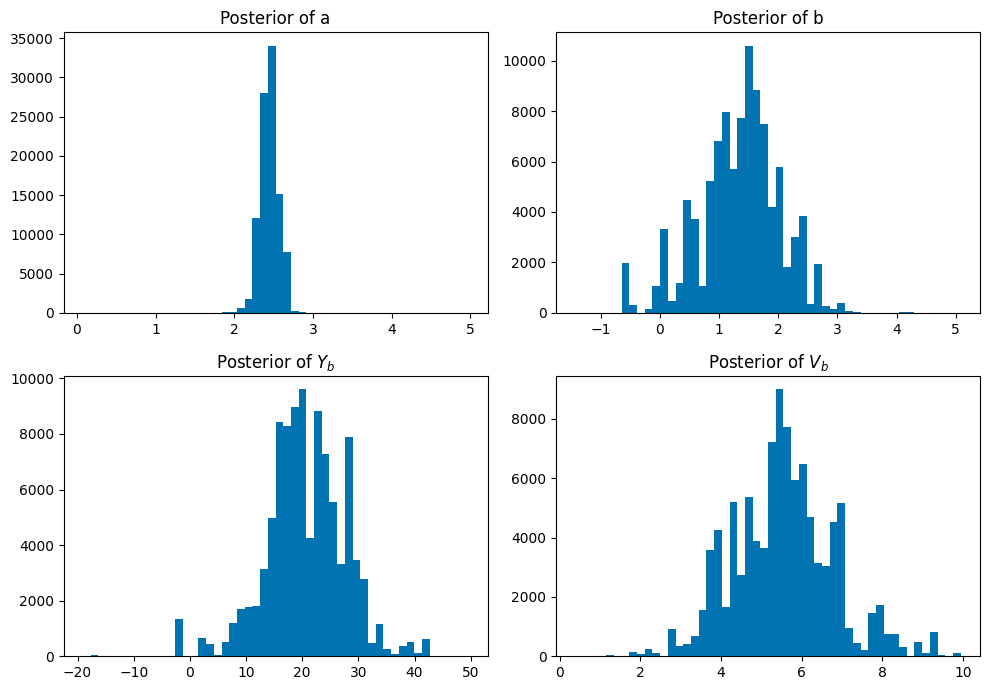

In [9]:
# plotting the posterior distribution of the parameters
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes[0, 0].hist(samples[:, :, 0].flatten(), bins=50, color='#0173b2')
axes[0, 0].set_title("Posterior of a")
axes[0, 1].hist(samples[:, :, 1].flatten(), bins=50, color='#0173b2')
axes[0, 1].set_title("Posterior of b")
axes[1, 0].hist(samples[:, :, 2].flatten(), bins=50, color='#0173b2')
axes[1, 0].set_title(r"Posterior of $Y_b$")
axes[1, 1].hist(samples[:, :, 3].flatten(), bins=50, color='#0173b2')
axes[1, 1].set_title(r"Posterior of $V_b$")
plt.tight_layout()
plt.show()

If we take a look at the posterior of the parameters, we can see what we would have expected from the results of the traces. The width of the peak of $a$ is fairly small, and for the other parameters it is wider.

Parameter a: 2.448 ± 0.136
Parameter b: 1.354 ± 0.686
Parameter Y_b: 20.720 ± 7.120
Parameter V_b: 5.540 ± 1.254


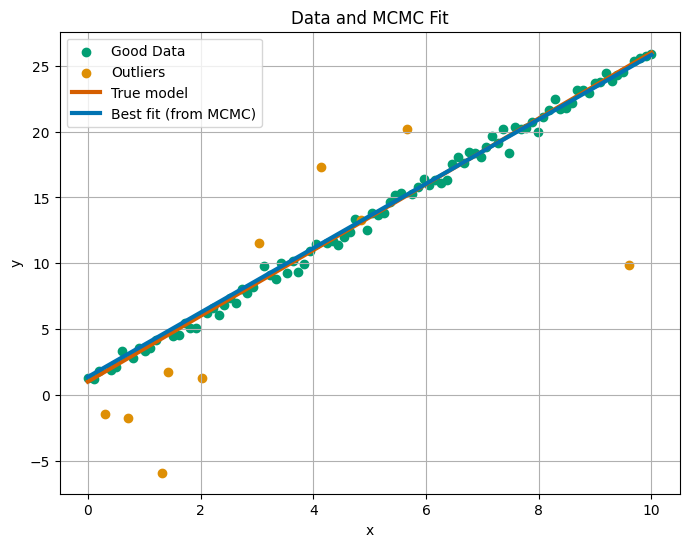

In [10]:
# extracting the posterior samples
a_samples = samples[:, :, 0].flatten()
b_samples = samples[:, :, 1].flatten()
Y_b_samples = samples[:, :, 2].flatten()
V_b_samples = samples[:, :, 3].flatten()

# computing the mean and standard deviation for each parameter
a_mean = np.mean(a_samples)
a_std = np.std(a_samples)
b_mean = np.mean(b_samples)
b_std = np.std(b_samples)
Y_b_mean = np.mean(Y_b_samples)
Y_b_std = np.std(Y_b_samples)
V_b_mean = np.mean(V_b_samples)
V_b_std = np.std(V_b_samples)

# Print the parameter values with errors (mean ± standard deviation)
print(f"Parameter a: {a_mean:.3f} ± {a_std:.3f}")
print(f"Parameter b: {b_mean:.3f} ± {b_std:.3f}")
print(f"Parameter Y_b: {Y_b_mean:.3f} ± {Y_b_std:.3f}")
print(f"Parameter V_b: {V_b_mean:.3f} ± {V_b_std:.3f}")

# plotting the original data
plt.figure(figsize=(8, 6))
# plotting good data
plt.scatter(x[~np.isin(np.arange(N), outliers)], y[~np.isin(np.arange(N), outliers)], label="Good Data", color='#029e73')
# plotting outliers
plt.scatter(x[outliers], y[outliers], label="Outliers", color='#de8f05')
# plotting true model
plt.plot(x, y_true, label="True model", color='#d55e00', linewidth=3)

# ploting the best-fit line using the extracted parameters
y_fit = a_mean * x + b_mean
plt.plot(x, y_fit, label="Best fit (from MCMC)", color='#0173b2', linewidth=3)
plt.title("Data and MCMC Fit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

Finally, we can see that the true parameters from the MCMC fit the data very well, even though we have quite a few fairly big outliers.

One might think: what is now our "answer"? Stricly speaking, the posterior distribution is our answer. However, often scientists want a specific answer, and not a distribution. One solution to this is, just like we did, simply choose the mean or the maximum of the posterior function. However, this is, in essence, ignoring the fundamental Bayesianism, as the "answer" is not just one value for each parameter, it is a distribution. The "better" solution is to use the posterior distribution we found and sample $M$ answers to the problem, instead of one. This one is prefered because it shows the uncertainties very clearly.

### Difference between Frequentists and Bayesian outlier rejection

The process of outlier rejection plays an important role in ensuring that the conclusions drawn from the data are reliable and representative of the underlying physical processes. Outlier rejection techniques vary depending on the philosophical approach to statistics. In frequentist statistics, a commonly used method is sigma clipping, while the Bayesian method offers a different approach to handling data and outliers. Each has its strengths and limitations.

Sigma clipping assumes that the data follows a normal distribution and defines outliers as data points lying a specified number of standard deviations away from the mean, removing outlier iteratively. As a frequentist method, it does not use any prior distribution or incorporate additional assumptions about the parameters or the underlying process generating the data. The method is purely based on likelihood, discarding unlikely data. This makes sigma clipping a simple technique. However, sigma clipping can be quite restrictive when dealing with more complex situations, for example if the data is not normally distributed. Also, the choice of from how many standard deviations a datapoint is considered an outlier, can be subjective. Lastly, since sigma clipping only removes outliers based on difference to the median, it may discard useful data or fail to identify subtle outliers.

In contrast to the frequentist approach, Bayesian statistics offers a different method for handling outliers, by making use of a prior. This need for a prior can be both an advantage, as well as a limitation. Priors allow us to incoporate our initial beliefs into the parameters, for example the fact that the probability will not be larger than one, but they can also be subjective, leading to biased results. Some see the need for priors as unfortunate. However, without priors we would not be able to marginalize (measure theory states that marginalization requires a measure, and that measure is provided by a prior), which is nessecary if we want to introduce more parameters beyond the model parameters, for example for the $P_b$ and $(Y_b, V_b)$. Furthermore, if there is enough data, the prior usually does not matter that much. However, one major advantage of using a prior is that we can marginalize the data, integrating out the parameters we do not directly observe. One consequence of this is that Bayesean statistics can become quite complex.

Therefore, both frequentist and Bayesian methods can be used for outlier rejection problems. Sigma clipping is simple, direct and effective, but it lacks some flexibility of the Bayesian method. On the other hand, the Bayesian method needs a prior to properly marginalize over the parameters, but it provides a more comprehensive framework for model uncertainty, especially with more complex systems. Ultimately, the choice between these methods depends on the problem at hand and the available data.

### sources:
[Hogg, D.W., et al. 2010, "Data analysis recipes: Fitting a model to data, chapter 2-3](https://arxiv.org/abs/1008.4686)

[Eddy, S. R. 2004, Nature Biotechnology, 22, 1177-1178](https://doi.org/10.1038/nbt0904-1177)

[Quimby, Robert, Sigma Clipping, 15-08-2023 - Youtube](https://www.youtube.com/watch?v=JYDzPXBzn2c)